In [ ]:
pip install emnist

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from emnist import list_datasets, extract_training_samples, extract_test_samples

In [ ]:
# load emnist dataset 'by class'

images, labels = extract_training_samples('byclass')
images_test, labels_test = extract_test_samples('byclass')

In [ ]:
# find index of uppercase letters

tr_index_UPP = [i for i in range(len(labels)) if labels[i]>=36 and labels[i] <= 61] 
ts_index_UPP = [i for i in range(len(labels_test)) if labels_test[i]>=36 and labels_test[i] <= 61]

In [ ]:
# save images and labels in uppercase

im_train_UPP = images[tr_index_UPP]
im_test_UPP = images_test[ts_index_UPP]
lab_train_UPP = labels[tr_index_UPP]
lab_test_UPP = labels_test[ts_index_UPP]

In [ ]:
# reformulate labels for application of built-in function 'to_categorical'

alf_UPP = {
       36: 0,
       37: 1,
       38: 2,
       39: 3,
       40: 4,
       41: 5,
       42: 6,
       43: 7,
       44: 8,
       45: 9,
       46: 10,
       47: 11,
       48: 12,
       49: 13,
       50: 14,
       51: 15,
       52: 16,
       53: 17,
       54: 18,
       55: 19,
       56: 20,
       57: 21,
       58: 22,
       59: 23,
       60: 24,
       61: 25,
       }

lab_train_UPP = [alf_UPP[label] for label in lab_train_UPP]
lab_test_UPP = [alf_UPP[label] for label in lab_test_UPP]

In [ ]:
# check labels

lab_train_UPP[0]

0

In [ ]:
# define image width and height and batch size

# Batch size for training and validation
batch_size = 32

# Desired image dimensions
img_width = 28
img_height = 28

In [ ]:
# split training set in traininig and validation set

def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

In [ ]:
# Splitting data into training and validation sets
x_train_UPP, x_valid_UPP, y_train_UPP, y_valid_UPP = split_data(np.array(im_train_UPP), np.array(lab_train_UPP))

In [ ]:
# to categorical 

y_train_UPP = tf.keras.utils.to_categorical(y_train_UPP, 26)
y_valid_UPP = tf.keras.utils.to_categorical(y_valid_UPP, 26)
lab_test_UPP = tf.keras.utils.to_categorical(lab_test_UPP, 26)

In [ ]:
# normalize training, validation and test data

x_train_UPP = tf.keras.utils.normalize(x_train_UPP, axis=1)
x_valid_UPP = tf.keras.utils.normalize(x_valid_UPP, axis=1)
im_test_UPP = tf.keras.utils.normalize(im_test_UPP, axis=1)

In [ ]:
# build model

def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    # First conv block
    x = layers.Conv2D(
        256,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2),padding='same',name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        128,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), padding='same',name="pool2")(x)

    # Third conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv3",
    )(x)
    x = layers.MaxPooling2D((2, 2), padding='same',name="pool3")(x)
    x = layers.Flatten()(x)
    
    # MLP + Output layer
    x = layers.Dense(units=128, activation='sigmoid', name='dense_1')(x)
    output = layers.Dense(units=26, activation="softmax", name="dense2")(x)

    # Define the model
    model = keras.models.Model(
        inputs=input_img, outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

    return model

In [ ]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 28, 28, 256)       2560      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 256)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 14, 14, 128)       295040    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 7, 7, 128)         0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 7, 7, 64)          73792     
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 4, 4, 64)         

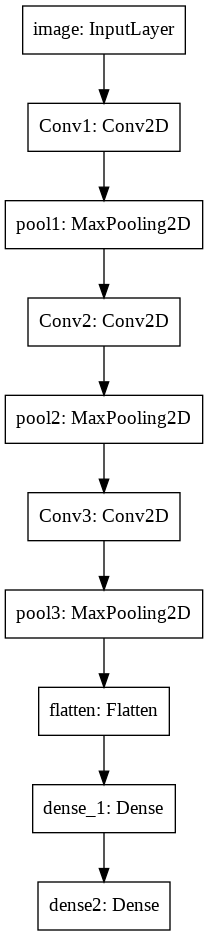

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='/content/drive/My Drive/TESI/Models/Immagini/model3_byclass_lower_noDA.png')

In [ ]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=early_stopping_patience, restore_best_weights=True, verbose=1
)

# Model CheckPoint
cp = keras.callbacks.ModelCheckpoint('/content/drive/My Drive/TESI/Models/model3_LOW_byclass_noDA.h5',
                                     verbose=1,
                                     monitor='val_accuracy',
                                     save_best_only=True)

In [ ]:
# fit model
history1_UPP = model.fit(x_train_UPP,y_train_UPP,
                    validation_data=(x_valid_UPP,y_valid_UPP),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[cp, early_stopping])

Epoch 1/100
4611/4611 [==============================] - ETA: 0s - loss: 0.3227 - accuracy: 0.9103
Epoch 00001: val_accuracy improved from -inf to 0.94187, saving model to /content/drive/My Drive/TESI/Models/model3_LOW_byclass_noDA.h5
4611/4611 [==============================] - 58s 13ms/step - loss: 0.3227 - accuracy: 0.9103 - val_loss: 0.1939 - val_accuracy: 0.9419
Epoch 2/100
4609/4611 [============================>.] - ETA: 0s - loss: 0.1683 - accuracy: 0.9483
Epoch 00002: val_accuracy improved from 0.94187 to 0.94931, saving model to /content/drive/My Drive/TESI/Models/model3_LOW_byclass_noDA.h5
4611/4611 [==============================] - 58s 13ms/step - loss: 0.1683 - accuracy: 0.9483 - val_loss: 0.1651 - val_accuracy: 0.9493
Epoch 3/100
4611/4611 [==============================] - ETA: 0s - loss: 0.1443 - accuracy: 0.9548
Epoch 00003: val_accuracy improved from 0.94931 to 0.95187, saving model to /content/drive/My Drive/TESI/Models/model3_LOW_byclass_noDA.h5
4611/4611 [========

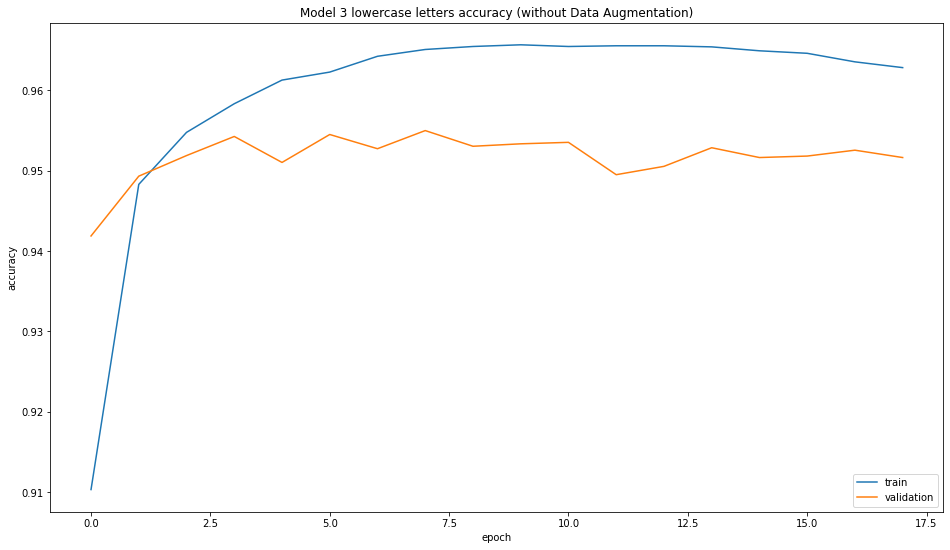

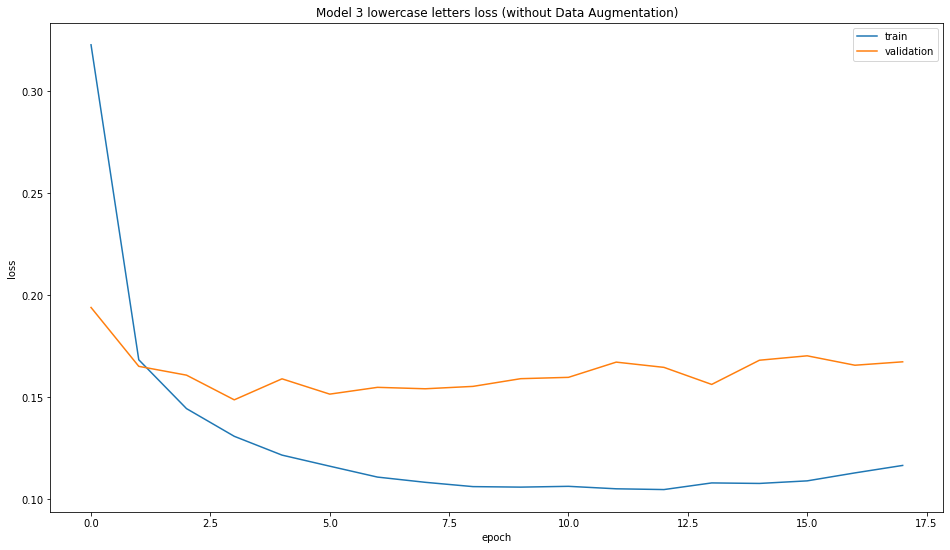

In [ ]:
plt.figure(figsize=(16,9))
# summarize history for accuracy
plt.plot(history1_UPP.history['accuracy'])
plt.plot(history1_UPP.history['val_accuracy'])
plt.title('Model 3 lowercase letters accuracy (without Data Augmentation)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
plt.figure(figsize=(16,9))

# summarize history for loss
plt.plot(history1_UPP.history['loss'])
plt.plot(history1_UPP.history['val_loss'])
plt.title('Model 3 lowercase letters loss (without Data Augmentation)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
evaluation = model.evaluate(im_test_UPP, lab_test_UPP)

846/846 [==============================] - 5s 6ms/step - loss: 0.1527 - accuracy: 0.9519


In [ ]:
evaluation

[0.15274710953235626, 0.9519198536872864]